## Прогнозирование поведения клиентов

#### Считываем выборку для анализа

In [2]:
import pandas as pd
import numpy as np

sample1 = pd.read_csv(
    'https://www.dropbox.com/s/t7xliiu0vz36geq/Sample.csv?dl=1',
    sep=";",
    encoding='cp1251',
    date_parser=lambda x: pd.to_datetime(x, format='%d%b%Y'), #преобразуем даты
    parse_dates=['statement_dt', 'generation_month']
)
sample1.head(10)

,account_rk,statement_dt,statement_num,generation_month,status_npv,pd,trans_amt,cash_amt,pd_bucket,pd_calibrated,PD_bucket_calibrated,default_flg,prev_act_flg,atr_flg,channel
0,1365508,2017-01-16,19,2015-07-01,CUR,0.08504,8000.0,0.0,3,0.079057,2,0,1,0,channel_1
1,1365508,2016-02-16,8,2015-07-01,CUR,0.08504,0.0,0.0,3,0.079057,2,0,1,0,channel_1
2,1365508,2017-05-16,23,2015-07-01,DLQ,0.08504,0.0,0.0,3,0.079057,2,0,1,0,channel_1
3,1365508,2016-05-16,11,2015-07-01,CUR,0.08504,0.0,0.0,3,0.079057,2,0,1,0,channel_1
4,1365508,2017-08-16,26,2015-07-01,CUR,0.08504,0.0,0.0,3,0.079057,2,0,1,0,channel_1
5,1365508,2016-12-16,18,2015-07-01,CUR,0.08504,0.0,0.0,3,0.079057,2,0,1,0,channel_1
6,1365508,2016-08-16,14,2015-07-01,CUR,0.08504,0.0,0.0,3,0.079057,2,0,1,0,channel_1
7,1365508,2016-04-16,10,2015-07-01,CUR,0.08504,0.0,0.0,3,0.079057,2,0,1,0,channel_1
8,1365508,2017-09-16,27,2015-07-01,CUR,0.08504,0.0,0.0,3,0.079057,2,0,1,0,channel_1
9,1365508,2017-04-16,22,2015-07-01,CUR,0.08504,0.0,0.0,3,0.079057,2,0,1,0,channel_1


 По каждому счету есть множество строк - полная история поведения клиента
 
 Generation_month - месяц первой расходной операции клиента. 
 Statement_num - номер месяца жизни в портфеле.

In [3]:
sample1.shape

(813515, 15)

#### Используем функцию pivot_table для создания сводных таблиц

In [4]:
sample1.pivot_table(values='account_rk', index='generation_month', aggfunc=np.count_nonzero, fill_value=0)

,account_rk
generation_month,
2015-07-01,272563
2016-04-01,327980
2017-01-01,212972


#### Разобьем каждое поколение generation_month по statement_num

In [5]:
sample1.pivot_table(values='account_rk', index='generation_month', columns='statement_num',
                    aggfunc=np.count_nonzero, fill_value=0)

statement_num,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
generation_month,,,,,,,,,,,,,,,,,,,,,
2015-07-01,8796,8796,8796,8796,8796,8796,8796,8796,8796,8796,...,8796,8796,8796,8796,8796,8796,8796,8793,8672,14
2016-04-01,14919,14919,14919,14919,14919,14919,14919,14919,14919,14919,...,6,0,0,0,0,0,0,0,0,0
2017-01-01,16390,16390,16390,16390,16390,16390,16390,16390,16390,16390,...,0,0,0,0,0,0,0,0,0,0


#### Рассмотрим распределение клиентов по статусам в каждом месяце:

In [6]:
def drop_rare_group(data):
    return data.groupby(['generation_month', 'statement_num']).filter(lambda x: x.shape[0] > 100)   
sample1 = drop_rare_group(sample1)  # убираем неполные данные - кол-во клиентов менее 100

pd.pivot_table(sample1,index=["generation_month","status_npv"], columns='statement_num',
               values="account_rk",
               aggfunc=np.count_nonzero, fill_value=0)

statement_num                   1      2      3      4      5      6      7   \
generation_month status_npv                                                    
2015-07-01       ATR            28    124    183    264    322    388    460   
                 CUR          8768   8055   7892   7604   7465   7298   7086   
                 DEF             0      0      0      0    126    199    297   
                 DLQ             0    617    721    928    883    911    953   
2016-04-01       ATR            70    163    267    383    473    555    651   
                 CUR         14849  13584  13106  12757  12477  12167  12032   
                 DEF             0      0      0      0    264    388    525   
                 DLQ             0   1172   1546   1779   1705   1809   1711   
2017-01-01       ATR            42    126    228    340    439    533    668   
                 CUR         16348  15583  14993  14723  14452  14148  13908   
                 DEF             0      0      0      0    172    271    349   
                 DLQ             0    681   1169   1327   1327   1438   1465   

statement_num                   8      9      10  ...     22    23    24  \
generation_month status_npv                       ...                      
2015-07-01       ATR           552    611    689  ...   1425  1469  1521   
                 CUR          7012   6830   6708  ...   5373  5271  5164   
                 DEF           363    409    483  ...   1314  1380  1433   
                 DLQ           869    946    916  ...    684   676   678   
2016-04-01       ATR           738    837    972  ...   2403     0     0   
                 CUR         11760  11623  11225  ...   8664     0     0   
                 DEF           679    789    903  ...   2366     0     0   
                 DLQ          1742   1670   1819  ...   1244     0     0   
2017-01-01       ATR           809    995   1168  ...      0     0     0   
                 CUR         13691  13336  13178  ...      0     0     0   
                 DEF           480    582    676  ...      0     0     0   
                 DLQ          1410   1477   1368  ...      0     0     0   

statement_num                  25    26    27    28    29    30    31  
generation_month status_npv                                            
2015-07-01       ATR         1582  1657  1716  1780  1829  1883  1926  
                 CUR         5056  4954  4880  4825  4770  4665  4514  
                 DEF         1475  1522  1567  1613  1665  1701  1724  
                 DLQ          683   663   633   578   532   544   508  
2016-04-01       ATR            0     0     0     0     0     0     0  
                 CUR            0     0     0     0     0     0     0  
                 DEF            0     0     0     0     0     0     0  
                 DLQ            0     0     0     0     0     0     0  
2017-01-01       ATR            0     0     0     0     0     0     0  
                 CUR            0     0     0     0     0     0     0  
                 DEF            0     0     0     0     0     0     0  
                 DLQ            0     0     0     0     0     0     0  

[12 rows x 31 columns]

#### Выделим одно поколение и нарисуем распределение:

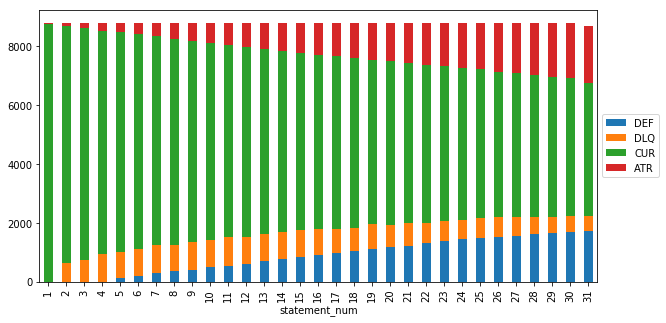

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt 

(pd.pivot_table(sample1,index=["generation_month","status_npv"], columns='statement_num',
                values="account_rk",
                aggfunc=np.count_nonzero, fill_value=0)
   .T #транспонирование
   ['2015-07-01'] #выделяем одно поколение
   [['DEF', 'DLQ', 'CUR', 'ATR']]  #зададим порядок слоев на графике
   .plot(kind='bar', stacked=True, figsize=(10, 5))
)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

#### Построим графики доли дефолта для разных поколений

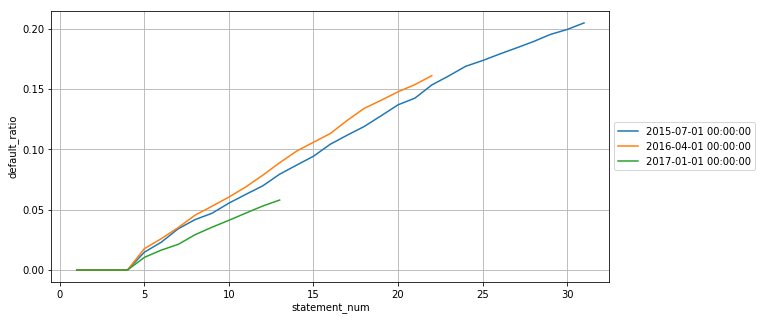

In [8]:
(sample1.pivot_table('default_flg', index='statement_num', columns='generation_month')
        .plot(figsize=(10, 5), grid=True))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('default_ratio');

#### Сравним уровень дефолта для разных поколений на 12й месяц - сделаем срез на 13й statement

In [9]:
(sample1.query('statement_num == 13')
        .groupby(["generation_month","statement_num"])
        .agg({"account_rk": np.count_nonzero, "default_flg": np.mean,  "pd": np.mean, "pd_calibrated": np.mean})
)

,,account_rk,default_flg,pd,pd_calibrated
generation_month,statement_num,,,,
2015-07-01,13,8796,0.079468,0.091229,0.079286
2016-04-01,13,14919,0.088947,0.114506,0.088063
2017-01-01,13,16282,0.058040,0.056075,0.059063


#### Имея данные о созревшем дефолте, откалибруем PD - модель, которая предсказывала просрочку 90+ на первые 12 платежей.
#### Разобьем на категории по откалиброванному PD (pd_bucket_calibrated).

In [10]:
(sample1.query('statement_num == 13')
        .groupby(["generation_month","statement_num", "PD_bucket_calibrated"])
        .agg({"account_rk": np.count_nonzero,"default_flg": np.mean,  "pd": np.mean, "pd_calibrated": np.mean})
        .rename(columns={'default_flg': 'default_ratio'})
)

account_rk  \
generation_month statement_num PD_bucket_calibrated               
2015-07-01       13            1                           1625   
                               2                           2464   
                               3                           3421   
                               4                           1286   
2016-04-01       13            1                           1172   
                               2                           4216   
                               3                           6673   
                               4                           2858   
2017-01-01       13            1                           5179   
                               2                           6405   
                               3                           4446   
                               4                            252   

                                                     default_ratio        pd  \
generation_month statement_num PD_bucket_calibrated                            
2015-07-01       13            1                          0.021538  0.032487   
                               2                          0.061688  0.061878   
                               3                          0.105232  0.114558   
                               4                          0.118196  0.159630   
2016-04-01       13            1                          0.016212  0.031001   
                               2                          0.061195  0.074242   
                               3                          0.096059  0.127322   
                               4                          0.143107  0.178223   
2017-01-01       13            1                          0.016026  0.023870   
                               2                          0.059485  0.056177   
                               3                          0.100540  0.089793   
                               4                          0.134921  0.120478   

                                                     pd_calibrated  
generation_month statement_num PD_bucket_calibrated                 
2015-07-01       13            1                          0.020504  
                               2                          0.062877  
                               3                          0.101098  
                               4                          0.126977  
2016-04-01       13            1                          0.019854  
                               2                          0.059859  
                               3                          0.095576  
                               4                          0.140098  
2017-01-01       13            1                          0.016135  
                               2                          0.061946  
                               3                          0.100403  
                               4                          0.138683

#### Рассмотрим кривые одного поколения в разрезе PD

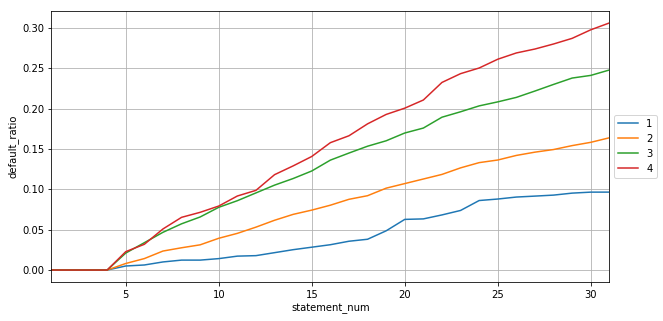

In [38]:
(sample1.pivot_table('default_flg', index='statement_num', columns=['generation_month', "PD_bucket_calibrated"])
         ['2015-07-01']
        .plot(figsize=(10, 5), grid=True))
        

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('default_ratio');

#### Выделим один бакет по PD и нарисуем графики "default ratio" для разных поколений

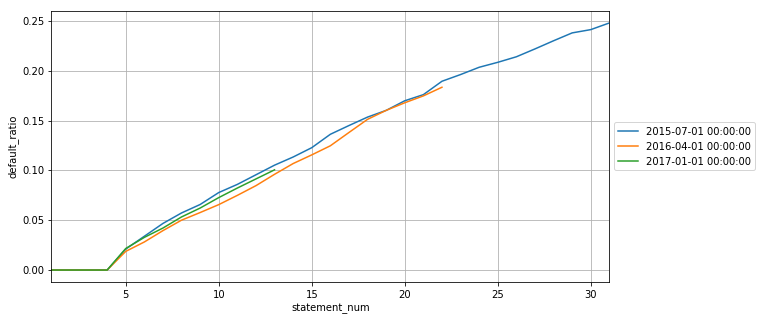

In [39]:
(sample1.query('PD_bucket_calibrated ==  3')
        .pivot_table('default_flg', index='statement_num', columns='generation_month')
        .plot(figsize=(10, 5), grid=True))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('default_ratio');

#### Рассмотрим скорость выпадения в дефолта. 
 Рассчитаем отношение "количество новых дефолтных клиентов / количество активных клиентов в предыдущем месяце"

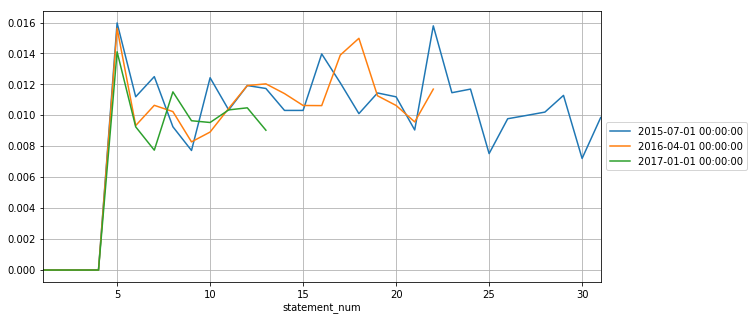

In [40]:
def plot_default_rate(ax=None):
    (sample1.eval('rate_flg = default_flg * prev_act_flg', inplace=False)
            .query('PD_bucket_calibrated == 2 or PD_bucket_calibrated == 3')
            .groupby(["generation_month","statement_num"])
            .agg({"rate_flg":np.sum, "prev_act_flg": np.sum})
            .eval('default_rate = rate_flg / prev_act_flg', inplace=False)
            .unstack('generation_month')
            ['default_rate']
            .plot(ax=ax, figsize=(10, 5), grid=True))

plot_default_rate()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

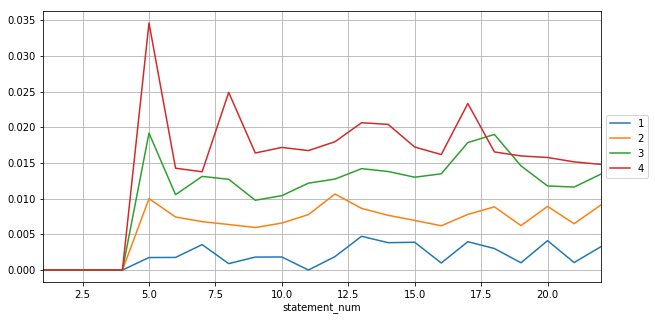

In [41]:
def plot_default_rate_by_PD(ax=None):
    (sample1.eval('rate_flg = default_flg * prev_act_flg', inplace=False)
            .query('generation_month == "2016-04-01"')
            .groupby(["PD_bucket_calibrated","statement_num"])
            .agg({"rate_flg":np.sum, "prev_act_flg": np.sum})
            .eval('default_rate = rate_flg / prev_act_flg', inplace=False)
            .unstack('PD_bucket_calibrated')
            ['default_rate']
            .plot(ax=ax, figsize=(10, 5), grid=True))

plot_default_rate_by_PD()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

#### Посчитаем среднее в разрезе одинаковых PD и построим модельную кривую

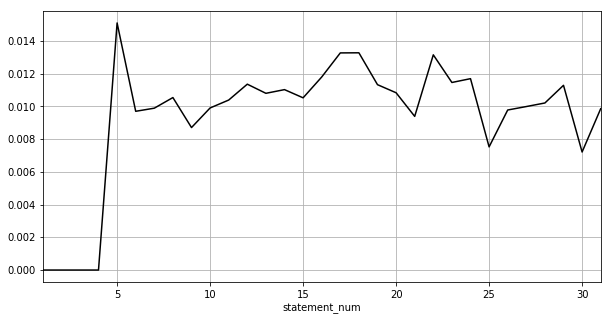

In [42]:
def plot_model_default_rate(ax=None):
    array = (
        sample1
        .eval('rate_flg = default_flg * prev_act_flg', inplace=False)
        .query('PD_bucket_calibrated == 2 or PD_bucket_calibrated == 3')
        .groupby(["statement_num"])
        .agg({"rate_flg":np.sum, "prev_act_flg": np.sum})
        .eval('default_rate = rate_flg / prev_act_flg', inplace=False)
        ['default_rate']
    )
    
    #array.loc[7:] = array.loc[7:].mean()
    return array.plot(ax=ax, color='black', figsize=(10, 5), grid=True)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plot_model_default_rate();

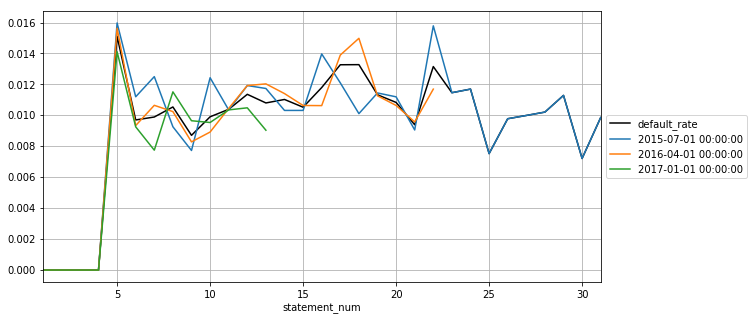

In [43]:
ax = plot_model_default_rate()
plot_default_rate(ax)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

### Домашнее задание

 #### Спрогнозировать выход в Attrition (ATR) - полное погашение кредита. 
 
Сделать анализ поколений из выборки с семинара. 
Для каждого клиента, который ушел в ATR, стоит прометка atr_flg=1 в том месяце, когда клиент поменял статус.

*  Построить кривые ATR ratio для разных поколений
*  Проанализировать зависимость ATR ratio от PD
*  Проанализировать зависимость ATR ratio от канала привлечения - поле "channel"
*  Построить модельную кривую - ATR (ratio/rate)

#### Спрогнозировать транзакционное поведение клиентов - доля снятия наличных среди всех транзакций клиента. 

Использовать выборку с семинара и поля:

Trans_amt - общая сумма транзакций в текущем месяце

Cash_amt - сумма снятия наличных в текущем месяце